# Pokémon battles — LightGBM with 10-fold CV
Notebook che implementa LightGBM con: feature engineering completo, 10-fold CV, Optuna hyperparameter tuning, e submission finale.

# Load data

In [2]:
import json
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# --- Percorsi ---
train_file_path = 'train.jsonl'
test_file_path = 'test.jsonl'

def load_jsonl(path):
    data = []
    with open(path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

print('Caricamento dati...')
train_raw = load_jsonl(train_file_path)
test_raw = load_jsonl(test_file_path)
print(f'Train records: {len(train_raw)}, Test records: {len(test_raw)}')

Caricamento dati...
Train records: 10000, Test records: 5000


# Feature Engineering

In [16]:
import math
from collections import Counter

# === TYPE CHART (Gen 1) ===
TYPE_CHART = {
    'normal': {'rock': 0.5, 'ghost': 0},
    'fire': {'fire': 0.5, 'water': 0.5, 'grass': 2, 'ice': 2, 'bug': 2, 'rock': 0.5, 'dragon': 0.5},
    'water': {'fire': 2, 'water': 0.5, 'grass': 0.5, 'ground': 2, 'rock': 2, 'dragon': 0.5},
    'grass': {'fire': 0.5, 'water': 2, 'grass': 0.5, 'poison': 0.5, 'ground': 2, 'flying': 0.5, 'bug': 0.5, 'rock': 2, 'dragon': 0.5},
    'electric': {'water': 2, 'grass': 0.5, 'electric': 0.5, 'ground': 0, 'flying': 2, 'dragon': 0.5},
    'ice': {'fire': 0.5, 'water': 0.5, 'grass': 2, 'ground': 2, 'flying': 2, 'dragon': 2},
    'fighting': {'normal': 2, 'ice': 2, 'poison': 0.5, 'flying': 0.5, 'psychic': 0.5, 'bug': 0.5, 'rock': 2, 'ghost': 0},
    'poison': {'grass': 2, 'poison': 0.5, 'ground': 0.5, 'bug': 2, 'rock': 0.5, 'ghost': 0.5},
    'ground': {'fire': 2, 'grass': 0.5, 'electric': 2, 'poison': 2, 'flying': 0, 'bug': 0.5, 'rock': 2},
    'flying': {'grass': 2, 'electric': 0.5, 'fighting': 2, 'bug': 2, 'rock': 0.5},
    'psychic': {'fighting': 2, 'poison': 2, 'psychic': 0.5, 'ghost': 0},
    'bug': {'fire': 0.5, 'grass': 2, 'fighting': 0.5, 'poison': 2, 'flying': 0.5, 'psychic': 2, 'ghost': 0.5},
    'rock': {'fire': 2, 'ice': 2, 'fighting': 0.5, 'ground': 0.5, 'flying': 2, 'bug': 2},
    'ghost': {'normal': 0, 'psychic': 0, 'ghost': 2},
    'dragon': {'dragon': 2}
}

def get_effectiveness(attack_type: str, defense_types: list) -> float:
    if not attack_type or not defense_types:
        return 1.0
    eff = 1.0
    for d in defense_types:
        eff *= TYPE_CHART.get(attack_type, {}).get(d, 1.0)
    return eff

def calculate_type_advantage(team1: list, team2_lead: dict) -> dict:
    out = {'p1_vs_lead_avg_effectiveness': 0.0, 'p1_vs_lead_max_effectiveness': 0.0, 'p1_super_effective_options': 0}
    if not team1 or not team2_lead:
        return out
    lead_types = [t.lower() for t in team2_lead.get('types', [])]
    if not lead_types:
        return out
    effs = []
    for p in team1:
        p_types = [t.lower() for t in p.get('types', [])]
        max_eff = 0.0
        for pt in p_types:
            max_eff = max(max_eff, get_effectiveness(pt, lead_types))
        effs.append(max_eff)
    if not effs:
        return out
    out['p1_vs_lead_avg_effectiveness'] = float(np.mean(effs))
    out['p1_vs_lead_max_effectiveness'] = float(np.max(effs))
    out['p1_super_effective_options'] = int(sum(1 for e in effs if e >= 2))
    return out

def _entropy(counter: Counter) -> float:
    total = sum(counter.values())
    if total == 0:
        return 0.0
    ent = 0.0
    for v in counter.values():
        p = v / total
        if p > 0:
            ent -= p * math.log(p, 2)
    return ent

def team_aggregate_features(team: list, prefix: str = 'p1_') -> dict:
    stats = ['base_hp','base_atk','base_def','base_spa','base_spd','base_spe']
    out = {}
    vals = {s: [] for s in stats}
    levels = []
    types_counter = Counter()
    names = []
    for p in team:
        names.append(p.get('name',''))
        for s in stats:
            vals[s].append(p.get(s, 0))
        levels.append(p.get('level', 0))
        for t in p.get('types', []):
            types_counter[t.lower()] += 1
    for s in stats:
        arr = np.array(vals[s], dtype=float)
        out[f'{prefix}{s}_sum'] = float(arr.sum())
        out[f'{prefix}{s}_mean'] = float(arr.mean())
        out[f'{prefix}{s}_max'] = float(arr.max())
        out[f'{prefix}{s}_min'] = float(arr.min())
        out[f'{prefix}{s}_std'] = float(arr.std())
    level_arr = np.array(levels, dtype=float)
    out[f'{prefix}level_mean'] = float(level_arr.mean()) if level_arr.size else 0.0
    out[f'{prefix}level_sum'] = float(level_arr.sum()) if level_arr.size else 0.0
    out[f'{prefix}n_unique_types'] = int(len(types_counter))
    common_types = ['normal','fire','water','electric','grass','psychic','ice','dragon','rock','ground','flying']
    for t in common_types:
        out[f'{prefix}type_{t}_count'] = int(types_counter.get(t, 0))
    out[f'{prefix}lead_name'] = names[0] if names else ''
    out[f'{prefix}n_unique_names'] = int(len(set(names)))
    out[f'{prefix}type_entropy'] = float(_entropy(types_counter))
    spe_arr = np.array(vals['base_spe'], dtype=float)
    out[f'{prefix}spe_p25'] = float(np.percentile(spe_arr, 25)) if spe_arr.size else 0.0
    out[f'{prefix}spe_p50'] = float(np.percentile(spe_arr, 50)) if spe_arr.size else 0.0
    out[f'{prefix}spe_p75'] = float(np.percentile(spe_arr, 75)) if spe_arr.size else 0.0
    return out

def lead_vs_lead_features(p1_lead: dict, p2_lead: dict) -> dict:
    out = {}
    stats = ['base_hp','base_atk','base_def','base_spa','base_spd','base_spe']
    for s in stats:
        out[f'lead_diff_{s}'] = float(p1_lead.get(s,0) - p2_lead.get(s,0))
    out['lead_speed_advantage'] = float(p1_lead.get('base_spe',0) - p2_lead.get('base_spe',0))
    p1_types = [t.lower() for t in p1_lead.get('types', [])]
    p2_types = [t.lower() for t in p2_lead.get('types', [])]
    max_eff = 0.0
    for pt in p1_types:
        max_eff = max(max_eff, get_effectiveness(pt, p2_types))
    out['lead_p1_vs_p2_effectiveness'] = float(max_eff)
    return out

def lead_aggregate_features(pokemon: dict, prefix: str = 'p2_lead_') -> dict:
    out = {}
    stats = ['base_hp','base_atk','base_def','base_spa','base_spd','base_spe']
    for s in stats:
        out[f'{prefix}{s}'] = float(pokemon.get(s,0))
    out[f'{prefix}level'] = int(pokemon.get('level',0))
    types = [x.lower() for x in pokemon.get('types', [])]
    common_types = ['normal','fire','water','electric','grass','psychic','ice','dragon','rock','ground','flying']
    for t in common_types:
        out[f'{prefix}type_{t}'] = int(t in types)
    out[f'{prefix}name'] = pokemon.get('name','')
    out[f'{prefix}n_unique_types'] = int(len(set(types)))
    return out

def quick_boost_features_v2(record: dict) -> dict:
    """Feature ad alto impatto senza bisogno team completo P2"""
    out = {}
    p1_team = record.get('p1_team_details', [])
    p2_lead = record.get('p2_lead_details', {})
    timeline = record.get('battle_timeline', [])
    
    if not p1_team:
        return out
    
    # 1. Speed Control: quanti pokemon più veloci del lead avversario
    p2_lead_spe = p2_lead.get('base_spe', 0)
    faster_count = sum(1 for p in p1_team if p.get('base_spe', 0) > p2_lead_spe)
    slower_count = sum(1 for p in p1_team if p.get('base_spe', 0) <= p2_lead_spe)
    
    out['p1_faster_than_lead_count'] = faster_count
    out['p1_slower_than_lead_count'] = slower_count
    out['p1_speed_control_ratio'] = faster_count / max(1, len(p1_team))
    
    # 2. Bulk vs Lead (resistenza)
    p1_avg_bulk = np.mean([
        p.get('base_hp', 0) * (p.get('base_def', 0) + p.get('base_spd', 0)) 
        for p in p1_team
    ])
    p2_lead_bulk = p2_lead.get('base_hp', 1) * (
        p2_lead.get('base_def', 1) + p2_lead.get('base_spd', 1)
    )
    out['p1_avg_bulk_vs_lead'] = p1_avg_bulk / max(p2_lead_bulk, 1)
    
    # 3. Offensive Power
    p1_total_atk = sum(p.get('base_atk', 0) + p.get('base_spa', 0) for p in p1_team)
    p2_lead_offense = p2_lead.get('base_atk', 0) + p2_lead.get('base_spa', 0)
    out['p1_total_offense'] = p1_total_atk
    out['p1_offense_advantage'] = p1_total_atk / max(p2_lead_offense, 1)
    
    # 4. Type Coverage Score (contro il lead)
    p2_lead_types = [t.lower() for t in p2_lead.get('types', [])]
    if p2_lead_types:
        coverage_scores = []
        for p in p1_team:
            p_types = [t.lower() for t in p.get('types', [])]
            max_eff = max([get_effectiveness(pt, p2_lead_types) for pt in p_types] or [1.0])
            coverage_scores.append(max_eff)
        
        out['p1_avg_effectiveness_vs_lead'] = float(np.mean(coverage_scores))
        out['p1_max_effectiveness_vs_lead'] = float(np.max(coverage_scores))
        out['p1_se_count_vs_lead'] = sum(1 for s in coverage_scores if s >= 2.0)
        out['p1_weak_count_vs_lead'] = sum(1 for s in coverage_scores if s <= 0.5)
    
    # 5. First blood: chi fa il primo KO?
    if timeline:
        first_p1_ko = False
        first_p2_ko = False
        
        for turn in timeline[:30]:
            p1_state = turn.get('p1_pokemon_state', {})
            p2_state = turn.get('p2_pokemon_state', {})
            
            if not first_p2_ko and p2_state.get('fainted'):
                first_p1_ko = True
                out['p1_first_blood'] = 1
                out['p1_first_blood_turn'] = turn.get('turn', 0)
                break
            
            if not first_p1_ko and p1_state.get('fainted'):
                first_p2_ko = True
                out['p1_first_blood'] = 0
                out['p1_first_blood_turn'] = turn.get('turn', 0)
                break
        
        if not first_p1_ko and not first_p2_ko:
            out['p1_first_blood'] = -1  # nessun KO nei primi 30 turni
            out['p1_first_blood_turn'] = 0
    
    # 6. Team Level Advantage
    p1_avg_level = np.mean([p.get('level', 50) for p in p1_team])
    p2_lead_level = p2_lead.get('level', 50)
    out['p1_avg_level_advantage'] = p1_avg_level - p2_lead_level
    
    # 7. Stat Product (indicatore qualità team)
    p1_stat_products = []
    for p in p1_team:
        stat_product = (
            p.get('base_hp', 1) * 
            p.get('base_atk', 1) * 
            p.get('base_def', 1) * 
            p.get('base_spa', 1) * 
            p.get('base_spd', 1) * 
            p.get('base_spe', 1)
        )
        p1_stat_products.append(stat_product)
    
    out['p1_avg_stat_product'] = float(np.mean(p1_stat_products))
    out['p1_max_stat_product'] = float(np.max(p1_stat_products))
    
    p2_lead_stat_product = (
        p2_lead.get('base_hp', 1) * 
        p2_lead.get('base_atk', 1) * 
        p2_lead.get('base_def', 1) * 
        p2_lead.get('base_spa', 1) * 
        p2_lead.get('base_spd', 1) * 
        p2_lead.get('base_spe', 1)
    )
    out['p1_stat_product_advantage'] = out['p1_avg_stat_product'] / max(p2_lead_stat_product, 1)
    
    return out

def summary_from_timeline(timeline: list, p1_team: list) -> dict:
    out = {}
    if not timeline:
        return {'tl_p1_moves':0,'tl_p2_moves':0,'tl_p1_est_damage':0.0,'tl_p2_est_damage':0.0,'damage_diff':0.0}
    p1_moves = p2_moves = 0
    p1_damage = p2_damage = 0.0
    p1_last_active = p2_last_active = ''
    p1_last_hp = p2_last_hp = np.nan
    p1_fainted = p2_fainted = 0
    p1_fainted_names = set()
    p2_fainted_names = set()
    last_p1_hp = {}
    last_p2_hp = {}
    p1_comeback_kos = 0
    p2_comeback_kos = 0
    p1_inflicted_statuses = Counter()
    p2_inflicted_statuses = Counter()
    p1_pokemon_statuses = {}
    p2_pokemon_statuses = {}
    p1_move_type_counts = Counter()
    p2_move_type_counts = Counter()
    p1_damage_first2 = 0.0
    p2_damage_first2 = 0.0
    p1_dmg_by_turn = {}
    p2_dmg_by_turn = {}
    seen_turns = set()
    first_ko_turn_p1_taken = None
    first_ko_turn_p1_inflicted = None
    early_threshold = 10
    p1_kos_early = p1_kos_late = 0
    p2_kos_early = p2_kos_late = 0

    for turn in timeline[:30]:
        prev_p1_fainted, prev_p2_fainted = p1_fainted, p2_fainted
        p1_state = turn.get('p1_pokemon_state',{}) or {}
        p2_state = turn.get('p2_pokemon_state',{}) or {}
        tnum = turn.get('turn', None)
        if tnum is None:
            tnum = (len(seen_turns) + 1)
        seen_turns.add(tnum)

        if p1_state.get('name'):
            p1_last_active = p1_state.get('name')
        if p2_state.get('name'):
            p2_last_active = p2_state.get('name')

        if p1_state.get('fainted') and p1_state.get('name') not in p1_fainted_names:
            p1_fainted += 1
            p1_fainted_names.add(p1_state.get('name'))
            if first_ko_turn_p1_taken is None:
                first_ko_turn_p1_taken = tnum
            if tnum <= early_threshold: p2_kos_early += 1
            else: p2_kos_late += 1
        if p2_state.get('fainted') and p2_state.get('name') not in p2_fainted_names:
            p2_fainted += 1
            p2_fainted_names.add(p2_state.get('name'))
            if first_ko_turn_p1_inflicted is None:
                first_ko_turn_p1_inflicted = tnum
            if tnum <= early_threshold: p1_kos_early += 1
            else: p1_kos_late += 1

        p2_name, p2_hp = p2_state.get('name'), p2_state.get('hp_pct')
        if p2_name and p2_hp is not None:
            prev_hp = last_p2_hp.get(p2_name)
            if prev_hp is not None:
                delta = max(0.0, prev_hp - p2_hp)
                p1_damage += delta
                p1_dmg_by_turn[tnum] = p1_dmg_by_turn.get(tnum, 0.0) + delta
                if turn.get('turn',999) <= 2:
                    p1_damage_first2 += delta
            last_p2_hp[p2_name] = p2_hp

        p1_name, p1_hp = p1_state.get('name'), p1_state.get('hp_pct')
        if p1_name and p1_hp is not None:
            prev_hp = last_p1_hp.get(p1_name)
            if prev_hp is not None:
                delta = max(0.0, prev_hp - p1_hp)
                p2_damage += delta
                p2_dmg_by_turn[tnum] = p2_dmg_by_turn.get(tnum, 0.0) + delta
                if turn.get('turn',999) <= 2:
                    p2_damage_first2 += delta
            last_p1_hp[p1_name] = p1_hp

        damage_diff_so_far = p1_damage - p2_damage
        if p2_fainted > prev_p2_fainted and damage_diff_so_far < -1.0:
            p1_comeback_kos += 1
        if p1_fainted > prev_p1_fainted and damage_diff_so_far > 1.0:
            p2_comeback_kos += 1

        p2_status = p2_state.get('status')
        if p2_name and p2_status and p2_pokemon_statuses.get(p2_name) != p2_status:
            p1_inflicted_statuses[p2_status] += 1
            p2_pokemon_statuses[p2_name] = p2_status
        p1_status = p1_state.get('status')
        if p1_name and p1_status and p1_pokemon_statuses.get(p1_name) != p1_status:
            p2_inflicted_statuses[p1_status] += 1
            p1_pokemon_statuses[p1_name] = p1_status

        p1_move = turn.get('p1_move_details') or {}
        p2_move = turn.get('p2_move_details') or {}
        if p1_move and p1_move.get('type'):
            p1_move_type_counts[(p1_move.get('type') or '').lower()] += 1
        if p2_move and p2_move.get('type'):
            p2_move_type_counts[(p2_move.get('type') or '').lower()] += 1
        if turn.get('p1_move_details'):
            p1_moves += 1
        if turn.get('p2_move_details'):
            p2_moves += 1
        p1_last_hp = p1_state.get('hp_pct', np.nan)
        p2_last_hp = p2_state.get('hp_pct', np.nan)

    out['tl_p1_moves'] = int(p1_moves)
    out['tl_p2_moves'] = int(p2_moves)
    out['tl_p1_est_damage'] = float(p1_damage)
    out['tl_p2_est_damage'] = float(p2_damage)
    out['tl_p1_fainted'] = int(p1_fainted)
    out['tl_p2_fainted'] = int(p2_fainted)
    turns_count = max(1, len(seen_turns))
    out['tl_p1_fainted_rate'] = float(out['tl_p1_fainted'] / turns_count)
    out['tl_p2_fainted_rate'] = float(out['tl_p2_fainted'] / turns_count)
    out['damage_diff'] = float(p1_damage - p2_damage)
    out['fainted_diff'] = int(p1_fainted - p2_fainted)
    out['tl_p1_last_hp'] = float(p1_last_hp) if not np.isnan(p1_last_hp) else 0.0
    out['tl_p2_last_hp'] = float(p2_last_hp) if not np.isnan(p2_last_hp) else 0.0
    out['tl_p1_last_active'] = p1_last_active
    out['tl_p2_last_active'] = p2_last_active
    if p1_team:
        p1_total_hp_sum = sum(p.get('base_hp',0) for p in p1_team)
        p1_avg_def = np.mean([p.get('base_def',0) for p in p1_team] or [0])
        p1_avg_spd = np.mean([p.get('base_spd',0) for p in p1_team] or [0])
        out['tl_p2_damage_vs_p1_hp_pool'] = float(p2_damage / (p1_total_hp_sum + 1e-6))
        out['tl_p1_defensive_endurance'] = float((p1_avg_def + p1_avg_spd) / (p2_damage + 1e-6))
    out['tl_p1_comeback_kos'] = int(p1_comeback_kos)
    out['tl_p2_comeback_kos'] = int(p2_comeback_kos)
    out['tl_comeback_kos_diff'] = int(p1_comeback_kos - p2_comeback_kos)

    common_statuses = ['brn','par','slp','frz','psn','tox']
    for status in common_statuses:
        out[f'tl_p1_inflicted_{status}_count'] = int(p1_inflicted_statuses.get(status,0))
        out[f'tl_p2_inflicted_{status}_count'] = int(p2_inflicted_statuses.get(status,0))
        out[f'tl_inflicted_{status}_diff'] = int(p1_inflicted_statuses.get(status,0) - p2_inflicted_statuses.get(status,0))

    common_move_types = ['normal','fire','water','electric','grass','psychic','ice','dragon','rock','ground','flying','ghost','bug','poison','fighting']
    for mt in common_move_types:
        out[f'tl_p1_move_type_{mt}_count'] = int(p1_move_type_counts.get(mt,0))
        out[f'tl_p2_move_type_{mt}_count'] = int(p2_move_type_counts.get(mt,0))
        out[f'tl_move_type_{mt}_count_diff'] = int(p1_move_type_counts.get(mt,0) - p2_move_type_counts.get(mt,0))

    out['tl_p1_damage_first2'] = float(p1_damage_first2)
    out['tl_p2_damage_first2'] = float(p2_damage_first2)
    out['tl_first2_damage_diff'] = float(p1_damage_first2 - p2_damage_first2)
    out['tl_turns_count'] = int(turns_count)
    out['tl_p1_moves_rate'] = float(p1_moves / turns_count)
    out['tl_p2_moves_rate'] = float(p2_moves / turns_count)
    out['tl_p1_damage_per_turn'] = float(p1_damage / turns_count)
    out['tl_p2_damage_per_turn'] = float(p2_damage / turns_count)
    out['tl_damage_rate_diff'] = float(out['tl_p1_damage_per_turn'] - out['tl_p2_damage_per_turn'])

    if seen_turns:
        recent_turns = sorted(seen_turns)[-5:]
        p1_last5 = sum(p1_dmg_by_turn.get(t,0.0) for t in recent_turns)
        p2_last5 = sum(p2_dmg_by_turn.get(t,0.0) for t in recent_turns)
    else:
        p1_last5 = p2_last5 = 0.0
    out['tl_p1_damage_last5'] = float(p1_last5)
    out['tl_p2_damage_last5'] = float(p2_last5)
    out['tl_last5_damage_diff'] = float(p1_last5 - p2_last5)
    out['tl_p1_last5_damage_ratio'] = float(p1_last5 / (p1_damage + 1e-6))
    out['tl_p2_last5_damage_ratio'] = float(p2_last5 / (p2_damage + 1e-6))
    out['tl_last5_damage_ratio_diff'] = float(out['tl_p1_last5_damage_ratio'] - out['tl_p2_last5_damage_ratio'])

    if seen_turns:
        ts = sorted(seen_turns)
        w = np.linspace(1.0, 2.0, num=len(ts))
        w = w / (w.sum() + 1e-9)
        adv = [(p1_dmg_by_turn.get(t,0.0) - p2_dmg_by_turn.get(t,0.0)) for t in ts]
        out['tl_weighted_damage_diff'] = float(np.dot(w, adv))
    else:
        out['tl_weighted_damage_diff'] = 0.0

    if seen_turns:
        ts = sorted(seen_turns)
        cum = 0.0
        signs = []
        for t in ts:
            cum += (p1_dmg_by_turn.get(t,0.0) - p2_dmg_by_turn.get(t,0.0))
            s = 1 if cum > 1e-9 else (-1 if cum < -1e-9 else 0)
            if s != 0:
                if not signs or signs[-1] != s:
                    signs.append(s)
        sign_flips = max(0, len(signs) - 1)
        comeback_flag = 1 if (len(signs) >= 2 and signs[0] != signs[-1]) else 0
    else:
        sign_flips = 0
        comeback_flag = 0
    out['tl_damage_adv_sign_flips'] = int(sign_flips)
    out['tl_comeback_flag'] = int(comeback_flag)

    out['tl_first_ko_turn_p1_inflicted'] = int(first_ko_turn_p1_inflicted or 0)
    out['tl_first_ko_turn_p1_taken'] = int(first_ko_turn_p1_taken or 0)
    out['tl_first_ko_turn_diff'] = int((first_ko_turn_p1_inflicted or 0) - (first_ko_turn_p1_taken or 0))
    out['tl_kos_early_p1'] = int(p1_kos_early)
    out['tl_kos_late_p1'] = int(p1_kos_late)
    out['tl_kos_early_p2'] = int(p2_kos_early)
    out['tl_kos_late_p2'] = int(p2_kos_late)

    for status in common_statuses:
        c1 = p1_inflicted_statuses.get(status,0)
        c2 = p2_inflicted_statuses.get(status,0)
        out[f'tl_p1_inflicted_{status}_rate'] = float(c1 / turns_count)
        out[f'tl_p2_inflicted_{status}_rate'] = float(c2 / turns_count)
        out[f'tl_inflicted_{status}_rate_diff'] = float((c1 - c2) / turns_count)

    return out

def extract_move_coverage_from_timeline(timeline: list, prefix: str = 'p1_') -> dict:
    """Analizza le mosse usate nella timeline per coverage e strategia"""
    out = {}
    
    move_types_used = set()
    move_categories_used = Counter()  # physical, special, status
    unique_moves = set()
    stab_count = 0  # mosse con STAB
    
    for turn in timeline[:30]:
        move_details = turn.get(f'{prefix[:-1]}_move_details')
        pokemon_state = turn.get(f'{prefix[:-1]}_pokemon_state', {})
        
        if not move_details:
            continue
            
        move_name = move_details.get('name', '')
        move_type = (move_details.get('type') or '').lower()
        move_category = move_details.get('category', '')
        
        if move_name:
            unique_moves.add(move_name)
        
        if move_type:
            move_types_used.add(move_type)
        
        if move_category:
            move_categories_used[move_category] += 1
        
        # Check STAB (Same Type Attack Bonus)
        pokemon_types = [t.lower() for t in pokemon_state.get('types', [])]
        if move_type in pokemon_types:
            stab_count += 1
    
    out[f'{prefix}tl_unique_move_types'] = len(move_types_used)
    out[f'{prefix}tl_unique_moves_used'] = len(unique_moves)
    out[f'{prefix}tl_stab_moves'] = stab_count
    out[f'{prefix}tl_physical_moves'] = move_categories_used.get('physical', 0)
    out[f'{prefix}tl_special_moves'] = move_categories_used.get('special', 0)
    out[f'{prefix}tl_status_moves'] = move_categories_used.get('status', 0)
    
    # Coverage score: più tipi = migliore coverage
    out[f'{prefix}tl_coverage_score'] = len(move_types_used) / max(1, len(unique_moves))
    
    # Offensive vs defensive strategy
    total_moves = sum(move_categories_used.values())
    if total_moves > 0:
        out[f'{prefix}tl_offensive_ratio'] = (
            move_categories_used.get('physical', 0) + 
            move_categories_used.get('special', 0)
        ) / total_moves
        out[f'{prefix}tl_status_ratio'] = move_categories_used.get('status', 0) / total_moves
    else:
        out[f'{prefix}tl_offensive_ratio'] = 0.0
        out[f'{prefix}tl_status_ratio'] = 0.0
    
    return out

def ability_features(team: list, prefix: str) -> dict:
    immunity_abilities = {'levitate':0,'volt_absorb':0,'water_absorb':0,'flash_fire':0}
    stat_drop_abilities = {'intimidate':0}
    weather_abilities = {'drought':0,'drizzle':0,'sand_stream':0}
    out = {}
    for pokemon in team:
        ability = (pokemon.get('ability','') or '').lower().replace(' ','_')
        if ability in immunity_abilities:
            immunity_abilities[ability] += 1
        if ability in stat_drop_abilities:
            stat_drop_abilities[ability] += 1
        if ability in weather_abilities:
            weather_abilities[ability] += 1
    for ability,count in immunity_abilities.items():
        out[f'{prefix}ability_{ability}_count'] = int(count)
    for ability,count in stat_drop_abilities.items():
        out[f'{prefix}ability_{ability}_count'] = int(count)
    for ability,count in weather_abilities.items():
        out[f'{prefix}ability_{ability}_count'] = int(count)
    out[f'{prefix}total_immunity_abilities'] = int(sum(immunity_abilities.values()))
    out[f'{prefix}total_stat_drop_abilities'] = int(sum(stat_drop_abilities.values()))
    return out

def momentum_features(timeline: list) -> dict:
    """Analizza momentum shift turn-by-turn"""
    out = {}
    
    if not timeline:
        return out
    
    p1_hp_changes = []
    p2_hp_changes = []
    p1_advantages = []  # vantaggio cumulativo
    
    cumulative_advantage = 0.0
    
    for i, turn in enumerate(timeline[:30]):
        p1_state = turn.get('p1_pokemon_state', {})
        p2_state = turn.get('p2_pokemon_state', {})
        
        # Calcola HP change
        p1_hp = p1_state.get('hp_pct', 100)
        p2_hp = p2_state.get('hp_pct', 100)
        
        # Vantaggio = HP P1 - HP P2 (semplificato)
        turn_advantage = p1_hp - p2_hp
        cumulative_advantage += turn_advantage
        p1_advantages.append(cumulative_advantage)
    
    if p1_advantages:
        # Trend momentum
        x = np.arange(len(p1_advantages))
        slope, intercept = np.polyfit(x, p1_advantages, 1)
        
        out['p1_momentum_slope'] = float(slope)
        out['p1_momentum_intercept'] = float(intercept)
        out['p1_final_advantage'] = float(p1_advantages[-1])
        
        # Volatilità vantaggio
        out['p1_advantage_volatility'] = float(np.std(p1_advantages))
        
        # Max/min advantage
        out['p1_max_advantage'] = float(np.max(p1_advantages))
        out['p1_min_advantage'] = float(np.min(p1_advantages))
        out['p1_advantage_range'] = float(np.max(p1_advantages) - np.min(p1_advantages))
    
    return out

def extract_opponent_team_from_timeline(timeline: list, p1_team: list) -> dict:
    """Ricostruisci info team avversario dalla timeline"""
    out = {}
    
    # Set di pokemon visti
    p2_pokemon_seen = set()
    p2_pokemon_types = []
    p2_pokemon_stats = []
    
    for turn in timeline[:30]:
        p2_state = turn.get('p2_pokemon_state', {})
        if not p2_state:
            continue
        
        p2_name = p2_state.get('name')
        if p2_name and p2_name not in p2_pokemon_seen:
            p2_pokemon_seen.add(p2_name)
            
            # Raccogli tipi
            types = p2_state.get('types', [])
            p2_pokemon_types.extend([t.lower() for t in types])
            
            # Prova a estrarre stats se disponibili (potrebbero non esserci)
            # ma possiamo inferire da HP loss patterns
    
    out['p2_tl_unique_pokemon_seen'] = len(p2_pokemon_seen)
    out['p2_tl_switches_count'] = len(p2_pokemon_seen) - 1  # switches = pokemon visti - 1
    
    # Type diversity avversario
    p2_type_counter = Counter(p2_pokemon_types)
    out['p2_tl_unique_types_seen'] = len(p2_type_counter)
    out['p2_tl_type_entropy'] = _entropy(p2_type_counter)
    
    # Matchup contro team P1 basato su tipi visti
    if p2_pokemon_types and p1_team:
        matchup_advantages = 0
        for p1_poke in p1_team:
            p1_types = [t.lower() for t in p1_poke.get('types', [])]
            for p1_type in p1_types:
                # Conta quanti tipi avversari siamo super-effective contro
                for p2_type in set(p2_pokemon_types):
                    eff = get_effectiveness(p1_type, [p2_type])
                    if eff >= 2.0:
                        matchup_advantages += 1
        
        out['p1_vs_p2_tl_type_advantages'] = matchup_advantages
        out['p1_vs_p2_tl_type_advantages_per_poke'] = matchup_advantages / max(1, len(p1_team))
    
    # Aggression score: quanti switch fa l'avversario?
    total_turns = len(timeline[:30])
    out['p2_tl_switch_rate'] = len(p2_pokemon_seen) / max(1, total_turns)
    
    return out

def prepare_record_features(record: dict, max_turns: int = 30) -> dict:
    out = {}
    out['battle_id'] = record.get('battle_id')
    if 'player_won' in record:
        out['player_won'] = int(bool(record.get('player_won')))
    p1_team = record.get('p1_team_details', [])
    out.update(team_aggregate_features(p1_team, prefix='p1_'))
    p2_lead = record.get('p2_lead_details', {})
    out.update(lead_aggregate_features(p2_lead, prefix='p2_lead_'))
    out.update(ability_features(p1_team, prefix='p1_'))
    p1_lead = p1_team[0] if p1_team else {}
    out.update(lead_vs_lead_features(p1_lead, p2_lead))
    out.update(ability_features([p2_lead], prefix='p2_lead_'))
    out['p1_intimidate_vs_lead'] = 1 if out.get('p1_ability_intimidate_count',0) > 0 else 0
    tl = record.get('battle_timeline', [])
    out.update(summary_from_timeline(tl[:max_turns], p1_team))

    out.update(extract_move_coverage_from_timeline(tl, prefix='p1_'))
    out.update(extract_move_coverage_from_timeline(tl, prefix='p2_'))
    out.update(extract_opponent_team_from_timeline(tl, p1_team))
    out.update(quick_boost_features_v2(record))
    out.update(momentum_features(tl))

    out['team_hp_sum_minus_p2lead_hp'] = out.get('p1_base_hp_sum', 0) - out.get('p2_lead_base_hp', 0)
    out['team_spa_mean_minus_p2spa'] = out.get('p1_base_spa_mean', 0) - out.get('p2_lead_base_spa', 0)
    out['speed_advantage'] = out.get('p1_base_spe_sum', 0) - out.get('p2_lead_base_spe', 0)
    out['n_unique_types_diff'] = out.get('p1_n_unique_types', 0) - out.get('p2_lead_n_unique_types', 1)
    p1_moves = max(out.get('tl_p1_moves',1),1)
    p2_moves = max(out.get('tl_p2_moves',1),1)
    out['damage_per_turn_diff'] = (out.get('tl_p1_est_damage',0.0)/p1_moves) - (out.get('tl_p2_est_damage',0.0)/p2_moves)
    out['last_pair'] = f"{out.get('tl_p1_last_active','')}_VS_{out.get('tl_p2_last_active','')}"
    out.update(calculate_type_advantage(p1_team, p2_lead))
    p2_lead_bulk = out.get('p2_lead_base_def',1) + out.get('p2_lead_base_spd',1)
    out['p1_se_options_vs_lead_bulk'] = out.get('p1_super_effective_options',0) / (p2_lead_bulk + 1e-6)
    p2_team = record.get('p2_team_details', [])
    if p2_team:
        out.update(team_aggregate_features(p2_team, prefix='p2_'))
        out['team_hp_sum_diff'] = out.get('p1_base_hp_sum',0) - out.get('p2_base_hp_sum',0)
        out['team_spa_mean_diff'] = out.get('p1_base_spa_mean',0) - out.get('p2_base_spa_mean',0)
        out['team_spe_mean_diff'] = out.get('p1_base_spe_mean',0) - out.get('p2_base_spe_mean',0)
        out['n_unique_types_team_diff'] = out.get('p1_n_unique_types',0) - out.get('p2_n_unique_types',0)
    return out

def create_features_from_raw(data: list) -> pd.DataFrame:
    rows = []
    for b in tqdm(data, desc='FE'):
        try:
            feat = prepare_record_features(b, max_turns=30)
            if 'battle_id' not in feat:
                feat['battle_id'] = b.get('battle_id')
            rows.append(feat)
        except Exception as e:
            rows.append({'battle_id': b.get('battle_id'), 'error': 1})
    df = pd.DataFrame(rows)
    if 'player_won' in df.columns:
        df['player_won'] = df['player_won'].astype(int)
    return df.fillna(0)

train_df = create_features_from_raw(train_raw)
test_df = create_features_from_raw(test_raw)
print('Feature shape train/test:', train_df.shape, test_df.shape)
display(train_df.head())

FE: 100%|██████████| 5000/5000 [00:05<00:00, 914.44it/s]


Feature shape train/test: (10000, 282) (5000, 281)


,battle_id,player_won,p1_base_hp_sum,p1_base_hp_mean,p1_base_hp_max,p1_base_hp_min,p1_base_hp_std,p1_base_atk_sum,p1_base_atk_mean,p1_base_atk_max,...,team_hp_sum_minus_p2lead_hp,team_spa_mean_minus_p2spa,speed_advantage,n_unique_types_diff,damage_per_turn_diff,last_pair,p1_vs_lead_avg_effectiveness,p1_vs_lead_max_effectiveness,p1_super_effective_options,p1_se_options_vs_lead_bulk
0,0,1,695.0,115.833333,250.0,55.0,69.367179,435.0,72.500000,110.0,...,635.0,0.000000,365.0,3,-0.070393,starmie_VS_snorlax,1.083333,2.0,1,0.005405
1,1,1,740.0,123.333333,250.0,65.0,64.204534,435.0,72.500000,110.0,...,685.0,-45.000000,250.0,4,-0.012174,tauros_VS_alakazam,1.000000,1.0,0,0.000000
2,2,1,745.0,124.166667,250.0,60.0,64.382753,505.0,84.166667,130.0,...,495.0,-15.000000,345.0,6,-0.000690,snorlax_VS_gengar,1.000000,1.0,0,0.000000
3,3,1,730.0,121.666667,250.0,60.0,65.362239,465.0,77.500000,110.0,...,655.0,33.333333,345.0,6,-0.014574,snorlax_VS_zapdos,1.000000,1.0,0,0.000000
4,4,1,685.0,114.166667,250.0,50.0,70.794107,455.0,75.833333,110.0,...,625.0,-2.500000,320.0,4,0.006923,tauros_VS_chansey,1.083333,2.0,1,0.005405


# Preprocessing

In [38]:
# Preprocessing - LightGBM gestisce bene valori raw (no scaling necessario)
exclude_cols = ['battle_id', 'player_won']
string_cols = train_df.select_dtypes(include=['object']).columns.tolist()
exclude_cols.extend(string_cols)

ALL_NUMERIC_FEATURES = [c for c in train_df.columns if c not in exclude_cols]
FEATURES = FEATURES_FINAL

print(f'Num FEATURES numeriche: {len(FEATURES)}')

# Imputazione mediana
num_df = train_df[FEATURES].astype(float).replace([np.inf, -np.inf], np.nan)
medians = num_df.median()
train_imputed = num_df.fillna(medians)
train_preproc_df = train_imputed.copy()

y = train_df['player_won'].astype(int).values
X = train_preproc_df.values

print('Preprocessing completato.')
print('Dataset completo size:', X.shape[0])
print('Features:', len(FEATURES))

# Allinea test
test_aligned = test_df.reindex(columns=FEATURES, fill_value=np.nan).astype(float).replace([np.inf, -np.inf], np.nan)
test_imputed = test_aligned.fillna(medians)
test_preproc_df = pd.DataFrame(test_imputed.values, columns=FEATURES, index=test_df.index)

Num FEATURES numeriche: 103
Preprocessing completato.
Dataset completo size: 10000
Features: 103


# Hyperparameter Optimization (Optuna + LightGBM)

In [ ]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

print("="*70)
print("OPTUNA HYPERPARAMETER TUNING - LIGHTGBM (ACCURACY ONLY)")
print("="*70)

N_TRIALS = 100
cv_optuna = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective_lightgbm(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'seed': 42,
        
        # Learning parameters
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000, step=100),
        
        # Tree structure
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
        
        # Regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        
        # Sampling
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
        
        # Other
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 128, 512, step=64)
    }
    
    fold_accs = []
    fold_gaps = []
    
    for train_idx, val_idx in cv_optuna.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        # LightGBM con early stopping
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
        )
        
        # Validation accuracy
        y_pred_val = model.predict(X_val)
        val_acc = accuracy_score(y_val, y_pred_val)
        
        # Train accuracy (solo per logging, non usato nell'objective)
        y_pred_tr = model.predict(X_tr)
        tr_acc = accuracy_score(y_tr, y_pred_tr)
        
        gap = tr_acc - val_acc
        fold_accs.append(val_acc)
        fold_gaps.append(gap)
        
        # Pruning basato solo su accuracy
        trial.report(val_acc, len(fold_accs))
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    mean_val_acc = float(np.mean(fold_accs))
    mean_gap = float(np.mean(fold_gaps))
    std_val = float(np.std(fold_accs))
    
    # ✅ OTTIMIZZA SOLO L'ACCURACY - nessuna penalty
    objective_score = mean_val_acc
    
    # Logga metriche per analisi post-hoc (senza influenzare l'ottimizzazione)
    trial.set_user_attr("mean_val_acc", mean_val_acc)
    trial.set_user_attr("mean_gap", mean_gap)
    trial.set_user_attr("std_val", std_val)
    
    return float(objective_score)

# Ottimizzazione
print(f"Avvio {N_TRIALS} trial Optuna (ottimizzazione SOLO accuracy)...\n")

study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42, n_startup_trials=20),
    pruner=MedianPruner(n_startup_trials=15, n_warmup_steps=3)
)

study.optimize(objective_lightgbm, n_trials=N_TRIALS, timeout=7200, gc_after_trial=True)

# Report
print("\n" + "="*70)
print("OPTUNA RESULTS - LIGHTGBM (ACCURACY OPTIMIZATION)")
print("="*70)
print(f"Best accuracy: {study.best_value*100:.2f}%")
print(f"Best trial: #{study.best_trial.number}")

best_attrs = study.best_trial.user_attrs
best_val_acc = best_attrs.get('mean_val_acc', 0.0)
best_gap = best_attrs.get('mean_gap', 0.0)
best_std = best_attrs.get('std_val', 0.0)

print(f"\n📊 Best trial metrics:")
print(f"  Mean CV accuracy:    {best_val_acc*100:.2f}%")
print(f"  Mean train-val gap:  {best_gap*100:.2f}% (non ottimizzato)")
print(f"  Std CV accuracy:     {best_std*100:.2f}% (non ottimizzato)")

print(f"\n⚙️ Best hyperparameters:")
for k, v in study.best_params.items():
    if isinstance(v, float):
        print(f"  {k:25s}: {v:.6f}")
    else:
        print(f"  {k:25s}: {v}")

# Salva risultati - FIX: estrai user_attrs manualmente
trials_df = study.trials_dataframe()

# ✅ CORRETTO: Aggiungi colonne user_attrs manualmente dai trial
mean_val_accs = []
mean_gaps = []
std_vals = []

for trial in study.trials:
    mean_val_accs.append(trial.user_attrs.get('mean_val_acc', np.nan))
    mean_gaps.append(trial.user_attrs.get('mean_gap', np.nan))
    std_vals.append(trial.user_attrs.get('std_val', np.nan))

trials_df['mean_val_acc'] = mean_val_accs
trials_df['mean_gap'] = mean_gaps
trials_df['std_val'] = std_vals

trials_df = trials_df.sort_values('value', ascending=False)
trials_df.to_csv('optuna_lightgbm_trials.csv', index=False)
print(f"\n✅ Salvati {len(trials_df)} trial in 'optuna_lightgbm_trials.csv'")

# Analisi distribuzione gap (informativa, non ha influenzato l'ottimizzazione)
valid_trials = trials_df[trials_df['state'] == 'COMPLETE'].copy()
if len(valid_trials) > 0:
    gaps = valid_trials['mean_gap'].dropna()
    if len(gaps) > 0:
        print(f"\n📈 DISTRIBUZIONE GAP (informativa, non ottimizzata):")
        print(f"  Mean: {gaps.mean()*100:.2f}%")
        print(f"  Std:  {gaps.std()*100:.2f}%")
        print(f"  Min:  {gaps.min()*100:.2f}%")
        print(f"  Max:  {gaps.max()*100:.2f}%")
        print(f"  Best trial gap: {best_gap*100:.2f}%")

# Assegna best_params
best_params = study.best_params.copy()
best_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'seed': 42
})

print(f"\n✅ Variabile 'best_params' pronta per CV")
print(f"⚠️  NOTA: Ottimizzato SOLO per accuracy. Controlla gap nella 10-fold CV!")

[I 2025-11-07 17:21:55,301] A new study created in memory with name: no-name-c06bea3a-d01c-4a0f-8683-0153ecebcb06


OPTUNA HYPERPARAMETER TUNING - LIGHTGBM (ACCURACY ONLY)
Avvio 100 trial Optuna (ottimizzazione SOLO accuracy)...



[I 2025-11-07 17:22:03,108] Trial 0 finished with value: 0.8225 and parameters: {'learning_rate': 0.02757359293934948, 'n_estimators': 2000, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 24, 'min_child_weight': 0.004207053950287938, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'subsample_freq': 1, 'min_split_gain': 0.9699098521619943, 'max_bin': 448}. Best is trial 0 with value: 0.8225.
[I 2025-11-07 17:22:10,243] Trial 1 finished with value: 0.8236999999999999 and parameters: {'learning_rate': 0.01777174904859463, 'n_estimators': 700, 'num_leaves': 44, 'max_depth': 6, 'min_child_samples': 57, 'min_child_weight': 0.05342937261279776, 'reg_alpha': 4.17890272377219e-06, 'reg_lambda': 0.0032112643094417484, 'subsample': 0.569746930326021, 'colsample_bytree': 0.6460723242676091, 'subsample_freq': 3, 'min_split_gain': 0.45606998421703593, 'max_bin': 448}. Best is trial 1 with value: 


OPTUNA RESULTS - LIGHTGBM (ACCURACY OPTIMIZATION)
Best accuracy: 82.70%
Best trial: #62

📊 Best trial metrics:
  Mean CV accuracy:    82.70%
  Mean train-val gap:  5.18% (non ottimizzato)
  Std CV accuracy:     0.53% (non ottimizzato)

⚙️ Best hyperparameters:
  learning_rate            : 0.048286
  n_estimators             : 600
  num_leaves               : 74
  max_depth                : 7
  min_child_samples        : 95
  min_child_weight         : 0.046044
  reg_alpha                : 0.001554
  reg_lambda               : 0.000040
  subsample                : 0.578947
  colsample_bytree         : 0.575072
  subsample_freq           : 2
  min_split_gain           : 0.741598
  max_bin                  : 320


KeyError: 'user_attrs'

# 10-Fold Cross-Validation

In [ ]:
print("=== 10-Fold Cross-Validation - LightGBM ===")
best_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'seed': 42,
    'learning_rate' : 0.048286,
    'n_estimators' : 600,
    'num_leaves' : 74,
    'max_depth' : 7,
    'min_child_samples' : 95,
    'min_child_weight' : 0.046044,
    'reg_alpha' : 0.001554,
    'reg_lambda' : 0.000040,
    'subsample' : 0.578947,
    'colsample_bytree' : 0.575072,
    'subsample_freq' : 2,
    'min_split_gain' : 0.741598,
    'max_bin' : 320
}

print(f"Parametri utilizzati: {best_params}\n")

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
outer_accuracies = []
train_accuracies = []
train_val_gaps = []
folds_info = []

fold_idx = 0
for train_idx, val_idx in skf.split(X, y):
    fold_idx += 1
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    # Train LightGBM con early stopping
    clf = lgb.LGBMClassifier(**best_params)
    clf.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
    )
    
    # Validation predictions
    y_pred_val = clf.predict(X_val)
    y_proba_val = clf.predict_proba(X_val)[:, 1]
    val_acc = accuracy_score(y_val, y_pred_val)
    outer_accuracies.append(val_acc)
    
    # Train accuracy
    y_pred_tr = clf.predict(X_tr)
    tr_acc = accuracy_score(y_tr, y_pred_tr)
    gap = tr_acc - val_acc
    train_accuracies.append(tr_acc)
    train_val_gaps.append(gap)
    
    # Best iteration info
    best_iter = clf.best_iteration_ if hasattr(clf, 'best_iteration_') else clf.n_estimators
    
    folds_info.append({
        'fold': fold_idx,
        'val_acc': float(val_acc),
        'train_acc': float(tr_acc),
        'gap': float(gap),
        'best_iteration': int(best_iter),
        'val_idx': val_idx,
        'y_true': y_val.astype(int),
        'y_pred': y_pred_val.astype(int),
        'y_proba': y_proba_val.astype(float)
    })
    
    print(f'Fold {fold_idx}: train={len(y_tr)}, val={len(y_val)}, '
          f'val_acc={val_acc*100:.2f}%, train_acc={tr_acc*100:.2f}%, '
          f'gap={gap*100:.2f}%, best_iter={best_iter}')

print('\n' + '='*60)
print('Risultati Cross-Validation')
print('='*60)
for i, info in enumerate(folds_info, 1):
    print(f"  Fold {i}: val_acc={info['val_acc']*100:.2f}%, "
          f"train_acc={info['train_acc']*100:.2f}%, gap={info['gap']*100:.2f}%")

print(f'\nMean CV accuracy: {np.mean(outer_accuracies)*100:.2f}%')
print(f'Std CV accuracy:  {np.std(outer_accuracies)*100:.2f}%')
print(f'Mean train accuracy: {np.mean(train_accuracies)*100:.2f}%')
print(f'Mean gap (train - val): {np.mean(train_val_gaps)*100:.2f}%')
print(f'Min/Max val acc:  {np.min(outer_accuracies)*100:.2f}% / {np.max(outer_accuracies)*100:.2f}%')

worst_idx = int(np.argmin(outer_accuracies))
print(f"\nPeggiore fold: #{worst_idx+1} con val_acc={outer_accuracies[worst_idx]*100:.2f}%")

=== 10-Fold Cross-Validation - LightGBM ===
Parametri utilizzati: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'seed': 42, 'learning_rate': 0.048286, 'n_estimators': 600, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 95, 'min_child_weight': 0.046044, 'reg_alpha': 0.05, 'reg_lambda': 0.1, 'subsample': 0.578947, 'colsample_bytree': 0.575072, 'subsample_freq': 2, 'min_split_gain': 0.741598, 'max_bin': 320}

Fold 1: train=9000, val=1000, val_acc=81.00%, train_acc=86.36%, gap=5.36%, best_iter=107
Fold 2: train=9000, val=1000, val_acc=84.50%, train_acc=89.76%, gap=5.26%, best_iter=235
Fold 3: train=9000, val=1000, val_acc=82.90%, train_acc=86.84%, gap=3.94%, best_iter=131
Fold 4: train=9000, val=1000, val_acc=84.20%, train_acc=87.74%, gap=3.54%, best_iter=160
Fold 5: train=9000, val=1000, val_acc=83.00%, train_acc=89.22%, gap=6.22%, best_iter=208
Fold 6: train=9000, val=1000, val_acc=82.60%, train_acc=89.32%, gap=6.72%, best_iter=218


In [31]:
# Aggiungi NUOVA CELLA dopo 10-Fold CV

print("="*70)
print("STABILITY SELECTION - FEATURE IMPORTANCES ACROSS FOLDS")
print("="*70)

# Raccogli importances da ogni fold
fold_importances = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    # Train model
    clf = lgb.LGBMClassifier(**best_params)
    clf.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
    )
    
    # Extract importances
    fold_imp = pd.DataFrame({
        'feature': FEATURES,
        'importance': clf.feature_importances_,
        'fold': fold_idx
    })
    fold_importances.append(fold_imp)

# Combina importances
all_importances = pd.concat(fold_importances, ignore_index=True)

# Calcola statistiche per feature
stability_stats = all_importances.groupby('feature')['importance'].agg([
    ('mean_importance', 'mean'),
    ('std_importance', 'std'),
    ('min_importance', 'min'),
    ('max_importance', 'max'),
    ('cv_importance', lambda x: x.std() / (x.mean() + 1e-9))  # Coefficient of Variation
]).reset_index()

# Ordina per mean importance
stability_stats = stability_stats.sort_values('mean_importance', ascending=False).reset_index(drop=True)

# 📊 IDENTIFICA FEATURE INSTABILI (alto CV = variance relativa alta)
HIGH_CV_THRESHOLD = 0.5  # feature con CV>0.5 sono instabili
unstable_features = stability_stats[
    stability_stats['cv_importance'] > HIGH_CV_THRESHOLD
]['feature'].tolist()

print(f"\n⚠️ Feature INSTABILI (CV importance >{HIGH_CV_THRESHOLD}):")
print(f"   Totale: {len(unstable_features)}")
print(f"   Queste feature variano molto tra fold → potenziale NOISE")
if unstable_features:
    print(f"   Esempi: {unstable_features[:15]}")

# 📊 IDENTIFICA FEATURE STABILI E IMPORTANTI
STABLE_CV_THRESHOLD = 0.3  # CV < 0.3
MIN_MEAN_IMPORTANCE = 10   # importance media > 10

stable_important_features = stability_stats[
    (stability_stats['cv_importance'] < STABLE_CV_THRESHOLD) &
    (stability_stats['mean_importance'] > MIN_MEAN_IMPORTANCE)
]['feature'].tolist()

print(f"\n✅ Feature STABILI e IMPORTANTI:")
print(f"   (CV <{STABLE_CV_THRESHOLD} AND mean_importance >{MIN_MEAN_IMPORTANCE})")
print(f"   Totale: {len(stable_important_features)}")

# Top 30 più stabili
print(f"\n🏆 Top 30 Feature più STABILI:")
display(stability_stats.head(30))

# Salva analisi
stability_stats.to_csv('feature_stability_analysis.csv', index=False)
print(f"\n✅ Analisi stabilità salvata in 'feature_stability_analysis.csv'")

# 🎯 LISTA FEATURE DA RIMUOVERE
features_to_remove = list(set(unstable_features))
print(f"\n🗑️ FEATURE DA RIMUOVERE ({len(features_to_remove)}):")
print(f"   {features_to_remove[:20]}")

# 🎯 FEATURE FILTRATE FINALI
FEATURES_STABLE = [f for f in FEATURES if f not in features_to_remove]
print(f"\n✅ FEATURES_STABLE creata: {len(FEATURES_STABLE)} feature (da {len(FEATURES)})")
print(f"   Rimosse: {len(features_to_remove)} feature instabili")

STABILITY SELECTION - FEATURE IMPORTANCES ACROSS FOLDS

⚠️ Feature INSTABILI (CV importance >0.5):
   Totale: 52
   Queste feature variano molto tra fold → potenziale NOISE
   Esempi: ['tl_move_type_ground_count_diff', 'p1_base_spd_sum', 'p1_type_normal_count', 'tl_p2_move_type_ground_count', 'p1_type_water_count', 'p1_base_spd_mean', 'p2_lead_base_def', 'p2_lead_type_water', 'tl_move_type_flying_count_diff', 'p1_vs_lead_avg_effectiveness', 'tl_p1_move_type_ground_count', 'p1_faster_than_lead_count', 'p2_lead_base_hp', 'p1_base_spa_min', 'p1_base_spe_max']

✅ Feature STABILI e IMPORTANTI:
   (CV <0.3 AND mean_importance >10)
   Totale: 83

🏆 Top 30 Feature più STABILI:


,feature,mean_importance,std_importance,min_importance,max_importance,cv_importance
0,tl_weighted_damage_diff,121.5,15.349629,94,144,0.126334
1,p2_tl_unique_pokemon_seen,120.5,10.255080,104,136,0.085104
2,tl_p2_last_hp,114.4,16.351690,94,148,0.142934
3,tl_p1_last_hp,104.0,15.874508,86,130,0.152639
4,tl_inflicted_par_diff,94.6,8.221922,76,105,0.086912
5,damage_diff,92.6,9.697651,76,109,0.104726
6,tl_p1_moves,89.3,7.874713,74,101,0.088183
7,damage_per_turn_diff,79.7,13.449907,60,105,0.168757
8,tl_p2_est_damage,78.6,7.486284,62,86,0.095245
9,tl_last5_damage_ratio_diff,73.8,16.995424,56,103,0.230290



✅ Analisi stabilità salvata in 'feature_stability_analysis.csv'

🗑️ FEATURE DA RIMUOVERE (52):
   ['p1_se_count_vs_lead', 'p1_type_grass_count', 'p2_lead_type_water', 'p1_slower_than_lead_count', 'tl_p2_inflicted_tox_rate', 'tl_p2_move_type_ground_count', 'tl_p1_move_type_ground_count', 'p1_base_spd_min', 'p2_lead_type_electric', 'p1_base_spd_max', 'tl_p2_move_type_water_count', 'p1_speed_control_ratio', 'p1_type_electric_count', 'p1_base_spd_mean', 'p1_base_atk_max', 'tl_p2_move_type_poison_count', 'p1_base_spa_max', 'p1_max_effectiveness_vs_lead', 'p1_base_hp_max', 'p1_type_water_count']

✅ FEATURES_STABLE creata: 223 feature (da 275)
   Rimosse: 52 feature instabili


# Feature Importance Analysis

=== Feature Importance Analysis ===
✅ Salvate 275 feature importances in 'lightgbm_feature_importances.csv'

Top 20 features più importanti:


,feature,importance
260,p1_momentum_intercept,332
99,tl_p1_est_damage,330
108,tl_p2_last_hp,328
191,tl_last5_damage_ratio_diff,313
270,damage_per_turn_diff,309
192,tl_weighted_damage_diff,307
188,tl_last5_damage_diff,294
107,tl_p1_last_hp,284
262,p1_advantage_volatility,282
265,p1_advantage_range,282


✅ Plot salvato in 'lightgbm_feature_importance.png'


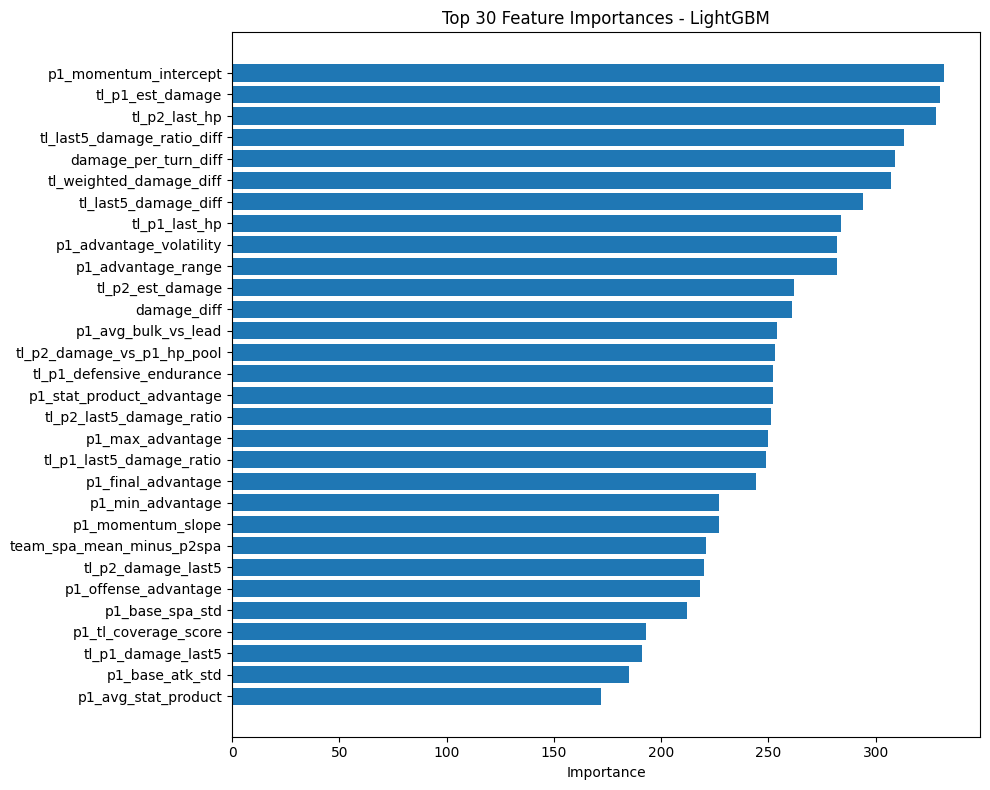

In [22]:
# Analizza feature importance dal modello finale
print("=== Feature Importance Analysis ===")

# Train su tutto il dataset per feature importance
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X, y)

# Estrai importances
importances = final_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': FEATURES,
    'importance': importances
}).sort_values('importance', ascending=False)

# Salva top features
importance_df.to_csv('lightgbm_feature_importances.csv', index=False)
print(f"✅ Salvate {len(importance_df)} feature importances in 'lightgbm_feature_importances.csv'")

print(f"\nTop 20 features più importanti:")
display(importance_df.head(20))

# Plot (opzionale, se matplotlib disponibile)
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 8))
    top_n = 30
    top_features = importance_df.head(top_n)
    plt.barh(range(top_n), top_features['importance'].values)
    plt.yticks(range(top_n), top_features['feature'].values)
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importances - LightGBM')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('lightgbm_feature_importance.png', dpi=150)
    print(f"✅ Plot salvato in 'lightgbm_feature_importance.png'")
except Exception as e:
    print(f"⚠️ Plot non disponibile: {e}")

In [36]:
# Nuova cella DOPO Feature Importance Analysis

from sklearn.inspection import permutation_importance

print("="*70)
print("PERMUTATION IMPORTANCE - IMPATTO REALE FEATURE")
print("="*70)

# Train modello su tutto dataset
perm_model = lgb.LGBMClassifier(**best_params)
perm_model.fit(X, y)

# Calcola permutation importance su validation set (usa un fold)
skf_perm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = next(skf_perm.split(X, y))
X_val_perm = X[val_idx]
y_val_perm = y[val_idx]

print("Calcolo permutation importance (può richiedere qualche minuto)...")
perm_result = permutation_importance(
    perm_model, X_val_perm, y_val_perm,
    n_repeats=10,  # ripeti shuffle 10 volte
    random_state=42,
    scoring='accuracy',
    n_jobs=-1
)

# Crea DataFrame risultati
perm_importance_df = pd.DataFrame({
    'feature': FEATURES,
    'perm_importance_mean': perm_result.importances_mean,
    'perm_importance_std': perm_result.importances_std,
}).sort_values('perm_importance_mean', ascending=False)

# 🎯 Feature con permutation importance NEGATIVA = DANNOSE
negative_impact_features = perm_importance_df[
    perm_importance_df['perm_importance_mean'] < 0
]['feature'].tolist()

print(f"\n⚠️ Feature con IMPATTO NEGATIVO (rimuoverle MIGLIORA accuracy):")
print(f"   Totale: {len(negative_impact_features)}")
if negative_impact_features:
    display(perm_importance_df[perm_importance_df['perm_importance_mean'] < 0])

# Feature con impatto quasi zero
NEGLIGIBLE_THRESHOLD = 0.001
negligible_features = perm_importance_df[
    (perm_importance_df['perm_importance_mean'] >= 0) &
    (perm_importance_df['perm_importance_mean'] < NEGLIGIBLE_THRESHOLD)
]['feature'].tolist()

print(f"\n📉 Feature con impatto TRASCURABILE (<{NEGLIGIBLE_THRESHOLD}):")
print(f"   Totale: {len(negligible_features)}")

# Top 30 feature per permutation importance
print(f"\n🏆 Top 30 Feature per PERMUTATION importance:")
display(perm_importance_df.head(30))

# Salva risultati
perm_importance_df.to_csv('permutation_importance_analysis.csv', index=False)
print(f"\n✅ Salvato in 'permutation_importance_analysis.csv'")

# 🎯 FEATURE DA RIMUOVERE (negative + negligible)
features_to_remove_perm = negative_impact_features + negligible_features
print(f"\n🗑️ RIMUOVI QUESTE FEATURE ({len(features_to_remove_perm)}):")
print(f"   {features_to_remove_perm[:20]}")

FEATURES_PERM_FILTERED = [f for f in FEATURES if f not in features_to_remove_perm]
print(f"\n✅ FEATURES_PERM_FILTERED: {len(FEATURES_PERM_FILTERED)} feature")

PERMUTATION IMPORTANCE - IMPATTO REALE FEATURE
Calcolo permutation importance (può richiedere qualche minuto)...

⚠️ Feature con IMPATTO NEGATIVO (rimuoverle MIGLIORA accuracy):
   Totale: 47


,feature,perm_importance_mean,perm_importance_std
85,lead_p1_vs_p2_effectiveness,-2.220446e-17,0.000316
206,tl_p2_inflicted_par_rate,-2.220446e-17,0.000548
173,tl_move_type_poison_count_diff,-5.000000e-05,0.000150
56,p2_lead_type_normal,-5.000000e-05,0.000269
11,p1_base_def_mean,-5.000000e-05,0.000522
242,p2_tl_switch_rate,-5.000000e-05,0.000789
26,p1_base_spe_mean,-5.000000e-05,0.000472
140,tl_move_type_water_count_diff,-5.000000e-05,0.000568
122,tl_inflicted_slp_diff,-5.000000e-05,0.001172
139,tl_p2_move_type_water_count,-1.000000e-04,0.000490



📉 Feature con impatto TRASCURABILE (<0.001):
   Totale: 145

🏆 Top 30 Feature per PERMUTATION importance:


,feature,perm_importance_mean,perm_importance_std
108,tl_p2_last_hp,0.01565,0.001501
238,p2_tl_unique_pokemon_seen,0.01510,0.002322
192,tl_weighted_damage_diff,0.01110,0.001758
107,tl_p1_last_hp,0.00955,0.001942
99,tl_p1_est_damage,0.00905,0.001331
259,p1_momentum_slope,0.00810,0.001091
191,tl_last5_damage_ratio_diff,0.00775,0.001601
270,damage_per_turn_diff,0.00735,0.001184
189,tl_p1_last5_damage_ratio,0.00695,0.001234
262,p1_advantage_volatility,0.00685,0.001629



✅ Salvato in 'permutation_importance_analysis.csv'

🗑️ RIMUOVI QUESTE FEATURE (192):
   ['lead_p1_vs_p2_effectiveness', 'tl_p2_inflicted_par_rate', 'tl_move_type_poison_count_diff', 'p2_lead_type_normal', 'p1_base_def_mean', 'p2_tl_switch_rate', 'p1_base_spe_mean', 'tl_move_type_water_count_diff', 'tl_inflicted_slp_diff', 'tl_p2_move_type_water_count', 'p1_base_spd_min', 'tl_inflicted_tox_rate_diff', 'p1_super_effective_options', 'tl_p2_inflicted_frz_rate', 'tl_p1_inflicted_frz_rate', 'p2_lead_base_hp', 'p1_spe_p75', 'p1_base_atk_mean', 'p2_lead_base_def', 'p2_lead_base_spe']

✅ FEATURES_PERM_FILTERED: 83 feature


In [37]:
# Nuova cella: COMBINE ALL ANALYSES

print("="*70)
print("FINAL FEATURE SELECTION - COMBINE ALL METHODS")
print("="*70)

# Combina risultati da tutte le analisi
all_bad_features = set()

# 1. Low importance
if 'low_importance_features' in globals():
    all_bad_features.update(low_importance_features)
    print(f"Low importance: {len(low_importance_features)}")

# 2. Unstable features
if 'unstable_features' in globals():
    all_bad_features.update(unstable_features)
    print(f"Unstable: {len(unstable_features)}")

# 3. Negative permutation importance
if 'negative_impact_features' in globals():
    all_bad_features.update(negative_impact_features)
    print(f"Negative impact: {len(negative_impact_features)}")

# 4. Manual removal
if 'MANUAL_REMOVE_FEATURES' in globals():
    all_bad_features.update(MANUAL_REMOVE_FEATURES)
    print(f"Manual: {len(MANUAL_REMOVE_FEATURES)}")

print(f"\n🗑️ TOTAL UNIQUE BAD FEATURES: {len(all_bad_features)}")

# 🎯 FINAL FILTERED FEATURES
FEATURES_FINAL = [f for f in ALL_NUMERIC_FEATURES if f not in all_bad_features]

print(f"\n✅ FINAL FEATURE SET:")
print(f"   Original: {len(ALL_NUMERIC_FEATURES)}")
print(f"   Removed:  {len(all_bad_features)}")
print(f"   Final:    {len(FEATURES_FINAL)}")
print(f"   Reduction: {(1 - len(FEATURES_FINAL)/len(ALL_NUMERIC_FEATURES))*100:.1f}%")

# Salva lista finale
with open('features_to_remove.txt', 'w') as f:
    for feat in sorted(all_bad_features):
        f.write(f"{feat}\n")

print(f"\n✅ Lista salvata in 'features_to_remove.txt'")

# 🎯 PER PROSSIMA RUN, USA:
print(f"\n📝 Per usare questo set, modifica cella Preprocessing:")
print(f"   FEATURES = FEATURES_FINAL")

FINAL FEATURE SELECTION - COMBINE ALL METHODS
Low importance: 143
Unstable: 52
Negative impact: 47

🗑️ TOTAL UNIQUE BAD FEATURES: 172

✅ FINAL FEATURE SET:
   Original: 275
   Removed:  172
   Final:    103
   Reduction: 62.5%

✅ Lista salvata in 'features_to_remove.txt'

📝 Per usare questo set, modifica cella Preprocessing:
   FEATURES = FEATURES_FINAL


In [25]:
# Aggiungi DOPO la cella Feature Importance Analysis

print("="*70)
print("FEATURE SELECTION - RIMOZIONE NOISE")
print("="*70)

# 1. Calcola statistiche importance
total_importance = importance_df['importance'].sum()
importance_df['importance_pct'] = (importance_df['importance'] / total_importance) * 100
importance_df['cumulative_importance'] = importance_df['importance_pct'].cumsum()

# 2. Identifica feature "rumore" (bassa importance)
LOW_IMPORTANCE_THRESHOLD = 0.1  # feature con <0.1% importance
low_importance_features = importance_df[
    importance_df['importance_pct'] < LOW_IMPORTANCE_THRESHOLD
]['feature'].tolist()

print(f"\n📉 Feature con importance <{LOW_IMPORTANCE_THRESHOLD}% (potenziale noise):")
print(f"   Totale: {len(low_importance_features)}")
print(f"   Esempi: {low_importance_features[:10]}")

# 3. Seleziona top N feature che spiegano X% della variance
CUMULATIVE_THRESHOLD = 95  # usa feature che spiegano 95% importance
top_features = importance_df[
    importance_df['cumulative_importance'] <= CUMULATIVE_THRESHOLD
]['feature'].tolist()

print(f"\n✅ Top features che spiegano {CUMULATIVE_THRESHOLD}% importance:")
print(f"   Totale selezionate: {len(top_features)} (da {len(FEATURES)})")
print(f"   Feature rimosse: {len(FEATURES) - len(top_features)}")

# 4. Mostra top 30 feature
print(f"\n🏆 Top 30 Feature più importanti:")
display(importance_df.head(30)[['feature', 'importance', 'importance_pct', 'cumulative_importance']])

# 5. Salva risultati
importance_df.to_csv('feature_importance_analysis.csv', index=False)
print(f"\n✅ Analisi completa salvata in 'feature_importance_analysis.csv'")

# 6. OPZIONE: Filtra feature per prossima run
FEATURES_FILTERED = top_features.copy()
print(f"\n🎯 Variabile FEATURES_FILTERED creata con {len(FEATURES_FILTERED)} feature")
print(f"   Per usarla, modifica la cella Preprocessing: FEATURES = FEATURES_FILTERED")

FEATURE SELECTION - RIMOZIONE NOISE

📉 Feature con importance <0.1% (potenziale noise):
   Totale: 143
   Esempi: ['tl_p2_inflicted_frz_count', 'tl_comeback_flag', 'p2_lead_base_spd', 'tl_p1_move_type_flying_count', 'p1_weak_count_vs_lead', 'p2_lead_base_atk', 'tl_p2_move_type_ghost_count', 'p1_base_spd_mean', 'p1_base_atk_max', 'p1_base_spa_max']

✅ Top features che spiegano 95% importance:
   Totale selezionate: 108 (da 275)
   Feature rimosse: 167

🏆 Top 30 Feature più importanti:


,feature,importance,importance_pct,cumulative_importance
260,p1_momentum_intercept,332,2.258964,2.258964
99,tl_p1_est_damage,330,2.245356,4.504321
108,tl_p2_last_hp,328,2.231748,6.736069
191,tl_last5_damage_ratio_diff,313,2.129686,8.865755
270,damage_per_turn_diff,309,2.102470,10.968225
192,tl_weighted_damage_diff,307,2.088862,13.057086
188,tl_last5_damage_diff,294,2.000408,15.057495
107,tl_p1_last_hp,284,1.932367,16.989862
262,p1_advantage_volatility,282,1.918759,18.908621
265,p1_advantage_range,282,1.918759,20.827380



✅ Analisi completa salvata in 'feature_importance_analysis.csv'

🎯 Variabile FEATURES_FILTERED creata con 108 feature
   Per usarla, modifica la cella Preprocessing: FEATURES = FEATURES_FILTERED


# Make Submission

In [9]:
print("=== Submission con LightGBM trainato su tutto il dataset ===")

# Train finale su tutto il dataset
submission_model = lgb.LGBMClassifier(**best_params)
submission_model.fit(X, y)

# Predict su test
X_test_matrix = test_preproc_df.values
test_predictions = submission_model.predict(X_test_matrix).astype(int)

# Crea submission
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'].astype(np.int64),
    'player_won': test_predictions.astype(np.int64)
})

submission_path = 'submission_lightgbm.csv'
submission_df.to_csv(submission_path, index=False)

print(f"✅ File di submission salvato in {submission_path}")
print(f"Modello: LightGBM trainato su {len(X)} samples")
print(f"Stima CV accuracy: {np.mean(outer_accuracies)*100:.2f}% ± {np.std(outer_accuracies)*100:.2f}%")
print(f"Mean gap: {np.mean(train_val_gaps)*100:.2f}%")
print("\nPreview submission:")
display(submission_df.head(10))
print(f"\nDistribuzione predizioni: {submission_df['player_won'].value_counts().to_dict()}")

=== Submission con LightGBM trainato su tutto il dataset ===
✅ File di submission salvato in submission_lightgbm.csv
Modello: LightGBM trainato su 10000 samples
Stima CV accuracy: 82.45% ± 1.00%
Mean gap: 5.41%

Preview submission:
✅ File di submission salvato in submission_lightgbm.csv
Modello: LightGBM trainato su 10000 samples
Stima CV accuracy: 82.45% ± 1.00%
Mean gap: 5.41%

Preview submission:


,battle_id,player_won
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
5,5,0
6,6,1
7,7,1
8,8,1
9,9,1



Distribuzione predizioni: {1: 2502, 0: 2498}
